# Flash 1 submission

Team members:
* Real Mario
* Fake Mario
* Suspicious Mario
* Derrick Timmermans

## Boilerplate code

### Imports

In [3]:
import networkx
from datetime import datetime
import csv
from typing import Any
from itertools import combinations
import pandas
import networkx as nx
import random as random
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats



### Basic types and aliases

In [4]:
# Just a struct to more easily represent collected entries
from dataclasses import dataclass

from typing import Hashable

Node = Hashable
Edge = tuple[Node, Node]
WeightedEdgeDict = dict[Edge, int]

@dataclass
class EntryStruct:
    def __init__(
        self,
        videoID: str,
        user1: str,
        user2: str,
        timestamp1: datetime,
        timestamp2: datetime,
    ) -> None:
        self.user1 = user1
        self.user2 = user2
        self.timestamp1 = timestamp1
        self.timestamp2 = timestamp2
        self.videoID = videoID
        pass

    @classmethod
    def datetimeFromCSVTimestamp(cls, csvTimestamp: str):
        return datetime.strptime(csvTimestamp, "%Y-%m-%d %H:%M:%S")

    @classmethod
    def fromEntryRow(cls, row: dict[str, Any]):
        return EntryStruct(
            row["videoID"],
            row["userID_1"],
            row["userID_2"],
            cls.datetimeFromCSVTimestamp(row["timestamp_1"]),
            cls.datetimeFromCSVTimestamp(row["timestamp_2"]),
        )

## Processing the dataset

### Loading the data set

In [59]:
entries: list[EntryStruct] = []

with open("pairwise_52seconds_share.csv", newline="") as csvfile:
    csvreader = csv.DictReader(csvfile)
    entries = [EntryStruct.fromEntryRow(row) for row in csvreader]

### Creating nodes for each unique user / video within the data set

In [60]:
userNodes = set[Node]()
videoNodes = set[Node]()

for entry in entries:
    userNodes.add(entry.user1)
    userNodes.add(entry.user2)
    videoNodes.add(entry.videoID)

### Computing trends and edges

In [ ]:
UserEngagementEdges: WeightedEdgeDict = {}
EngagementTargetEdges: WeightedEdgeDict = {}
VideoEngagementPeriodEdges: WeightedEdgeDict = {}
RelationEdges: WeightedEdgeDict = {}

userEngagementNodes = set[Node]()
engagementPeriodNodes = set[Node]()


# Helper function to increment edge weights when the edge already exist
def addOrUpdateEdge(edgesDict: WeightedEdgeDict, edge: Edge):
    edgesDict[edge] = edgesDict[edge] + 1 if edge in edgesDict else 1


# Create a chronologically ordered list of all video sharing activity by each user
# Due to the usage of sets, this will also filter erroneous entries where the same user shared the same video multiple times at the same time
shareEvents = list(
    set(
        [(e.user1, e.timestamp1, e.videoID) for e in entries]
        + [(e.user2, e.timestamp2, e.videoID) for e in entries]
    )
)

# Sorting in-place rather than a sort+copy via `sorted()`
shareEvents.sort(key=lambda tup: tup[1])

# This copy of share events is augmented with the probable starting date time of a trend
augmentedShareEvents = list[tuple[str, datetime, str, datetime]]()

lastTime: datetime = datetime(1980, 1, 1)
currentTimeStampBatch = datetime(1980, 1, 1)

# Let's try to assign each share event into a trend period
for event in shareEvents:
    # A datetime is the original of it's own trend period if it is more than 24 hrs apart since the last share datetime
    # Each trend period will get its own node to represent the preiod
    if (event[1] - lastTime).total_seconds() > 60 * 60 * 24:
        currentTimeStampBatch = event[1]
        engagementPeriodNodes.add(currentTimeStampBatch)

    lastTime = event[1]
    augmentedShareEvents.append((event[0], currentTimeStampBatch, event[2], event[1]))

# Let's try to find pairs of users who shared the same video within a 52 second timespan
# Bloom: Yes I know that the original dataset contained that information,
#   yet I am excluding it since I then adjust the "closeness interval" to something else if I desire
pairs = [
    item
    for item in combinations(augmentedShareEvents, 2)
    if abs((item[0][3] - item[1][3]).total_seconds()) < 52
    and item[0][2] == item[1][2]  # Video must be the same
]

# Add bidirectional edges for share buddies
for item in pairs:
    addOrUpdateEdge(RelationEdges, (item[0][0], item[1][0]))
    addOrUpdateEdge(RelationEdges, (item[1][0], item[0][0]))

# Add edges for each share event
for event in augmentedShareEvents:
    # Add weight to an edge between the user and the trend node
    addOrUpdateEdge(EngagementTargetEdges, (event[0], event[1]))

    # Add weight to an edge between the trend node and the target video
    addOrUpdateEdge(VideoEngagementPeriodEdges, (event[1], event[2]))

## Creating the graph

### Helper functions

In [62]:
nodeID = 0
nodeIDMap: dict[str, int] = {}
# This function is used to assign simpler IDs for node identifiers
def getNodeIDFor(label: Any):
    global nodeID
    if label in nodeIDMap:
        return nodeIDMap[label]

    nodeIDMap[label] = nodeID
    nodeID += 1
    return nodeIDMap[label]

def addEdgesToGraph(
    G: networkx.Graph, edges: WeightedEdgeDict, edgeType: str, bidirectional=False
):
    for edge in edges:
        weight = edges[edge]
        u = getNodeIDFor(edge[0])
        v = getNodeIDFor(edge[1])
        G.add_edge(u, v, edgeType=edgeType, weight=weight)
        if bidirectional:
            G.add_edge(v, u, edgeType=edgeType, weight=weight)

def addNodesToGraph(G: networkx.Graph, nodes: set[Node], nodeType: str):
    for node in nodes:
        G.add_node(getNodeIDFor(node), type=nodeType, label=node)


In [ ]:
G_ws = networkx.DiGraph()

addNodesToGraph(G_ws, engagementPeriodNodes, "EngagementPeriod")
addNodesToGraph(G_ws, userNodes, "User")
addNodesToGraph(G_ws, videoNodes, "Video")

addEdgesToGraph(G_ws, RelationEdges, "RelationEdges")
addEdgesToGraph(G_ws, VideoEngagementPeriodEdges, "EngagementPeriodEdge")
addEdgesToGraph(G_ws, EngagementTargetEdges, "EngagementTarget")


print(G_ws.number_of_nodes())
print(G_ws.number_of_edges())

4476
12518


### Exporting to gexf

In [ ]:
networkx.write_gexf(G_ws, "graph.gexf")

### Render using gephi

The above `.gexf` file can be imported into Gephi, in order to render/visualize the network. 

The following are the steps I've taken:
1. Color the nodes based on `Type` attribute
2. Size the nodes based on `Weighted in-degree`
   * Min size = 10
   * Max Size = 150
   * Spline easing = Circular
3. Ran the ForceAtlas2 layouting algorithm
   * Default settings, with `Gravity=500` and `Scaling=100` 
4. Color the edges based on the target node's color
5. Rescaled the edge weights to $[10, 100]$

The following image shows the processed dataset from above.

* Green nodes are Trend node, indicating a lot of activity all occurring within a day of each other.
* Purple nodes are Users.
* Orange nodes are Videos.


![Image](renders/Gephi-render.svg)

In [5]:
import math


def connectedComponents(G: nx.Graph | nx.MultiGraph):
    return len([c for c in nx.connected_components(G)])


def avgClusteringCoeff(G: nx.Graph | nx.MultiGraph):
    try:
        avg_clustering = nx.average_clustering(G)
    except:
        return -1

    return avg_clustering


def modularity(G: nx.Graph | nx.MultiGraph):
    return nx.community.modularity(
        G, [x for x in nx.community.greedy_modularity_communities(G)]
    )


def printStats(G: nx.Graph | nx.MultiGraph):
    ds = [d for _, d in G.degree()]  # type:ignore
    paths = [j.values() for (i, j) in nx.shortest_path_length(G)]
    avgLength = np.mean([max(j) for j in paths])
    maxLength = np.max([max(j) for j in paths])
    print(f"Nodes: {len(G.nodes)}")
    print(f"Edges: {len(G.edges)}")
    print(f"Degree: (Min: {np.min(ds)}, Max: {np.max(ds)}, Avg: {np.mean(ds)})")
    print(f"Connected components: {connectedComponents(G)}")
    print(f"Avg path length: {avgLength}")
    print(f"Diameter: {maxLength}")
    print(f"Radius: {maxLength / 2}")
    print(f"Average clustering coeff: {avgClusteringCoeff(G)}")
    print(f"Modularity: {modularity(G)}")

### Create User-User Graph 

In [6]:
df = pandas.read_csv('data/pairwise_52seconds_share.csv')

filtered_df = df[df['userID_1'] != df['userID_2']]

network = filtered_df[['userID_1', 'userID_2']]

G = nx.from_pandas_edgelist(network, 'userID_1', 'userID_2')
nx.write_gexf(G, "networks/all_users.gexf")

n_nodes_og = G.number_of_nodes()
n_edges_og = G.number_of_edges()
average_degree_og = 2 * n_edges_og / n_nodes_og
print(n_nodes_og, n_edges_og, average_degree_og)

4030 4078 2.023821339950372


![Image](renders/UserNet.svg)

### WS Graph

Analysis of the Watts-Strogatz (WS) Model Fit to the White Helmets Network
In exploring the potential of the Watts-Strogatz (WS) model for representing the White Helmets network structure, we aimed to configure a WS model with the same node and edge count as the original network (OG model) while observing five primary network metrics: average degree, path length, diameter, clustering coefficient, and modularity. However, unlike the Barabási–Albert (BA) model, the WS model presented considerable challenges in capturing the network’s structural characteristics. Here's an analysis of the approach, results, and limitations encountered.

Initial Attempt: Watts-Strogatz Model Configuration

Node and Edge Counts: The WS model was initialized with identical node and edge counts as the White Helmets network, ensuring a basis for comparison across structural metrics.

Average Degree: Setting an initial target average degree of 2.02, matching the OG model, was not achievable with the WS model. Adjustments were needed in the connection probability parameter p to control the random edge rewiring. However, maintaining the desired average degree while ensuring network connectivity proved challenging since adjusting p could lead to isolated nodes or disconnected components.

Connection Probability and Model Challenges

Connection Probability (p): The WS model requires a rewiring probability parameter p to introduce randomness in the network. To avoid isolated nodes and maintain connectivity, we started with a higher value of p (set to 1 initially), which produced a connected network but did not align with the OG network’s average degree or clustering coefficient.

Disconnection and Rewiring Issues: With p set to a lower value, as required to reduce edge density, the network often became disconnected, generating isolated clusters that are uncharacteristic of the White Helmets network’s connectivity structure. Therefore, careful control of edge removal and rewiring was essential to approximate the OG model’s structure.

Approach: Iterative Edge Removal to Achieve Structural Consistency

To overcome these issues, we implemented a custom edge removal function, safe_remove_edge, designed to iteratively remove edges while preventing isolated nodes:

Safe Edge Removal: The safe_remove_edge function verifies node degrees before removing an edge to ensure no node becomes isolated. This helps maintain the structural integrity of the network during edge reduction.

Controlled Edge Reduction: By removing a fifth of the edges iteratively and checking the number of connected components, we aimed to bring the WS model closer to the OG model’s modular structure without excessive fragmentation.

Outcome: Observations and Limitations

Component Connectivity: After several iterations, the modified WS network still displayed a different structure from the OG model. The requirement to maintain connectivity while achieving an average degree similar to the OG network proved limiting within the WS framework.

Average Degree and Clustering Coefficient: The final average degree was closer to the OG network’s target, but the clustering coefficient remained higher, as the WS model tends to form tightly-knit clusters that differ from the White Helmets network’s more evenly distributed connections.

Disconnected Components and Isolated Nodes: Despite controlled edge removal, achieving the correct number of connected components without forming isolated nodes remained challenging. The WS model’s underlying small-world properties did not align well with the White Helmets network’s structural characteristics, suggesting fundamental differences in network topology.

Assessment and Conclusion

The attempt to replicate the White Helmets network’s structure using the WS model highlighted key mismatches:

Degree Distribution: The WS model could not match the OG model’s degree distribution and lacked flexibility in forming the evenly distributed connections seen in the White Helmets network.
Path Length and Clustering: The WS model’s small-world characteristics lead to shorter path lengths and higher clustering coefficients than observed in the OG network.

In [9]:
# WS graph

n_nodes_ws = n_nodes_og
average_degree_ws = 1000
p = 1

G_ws = nx.watts_strogatz_graph(n_nodes_ws, average_degree_ws, p)

def safe_remove_edge(G, edge):
    u, v = edge
    # Check degrees before removal
    degree_u = G.degree(u)
    degree_v = G.degree(v)
    
    # If removing the edge doesn't isolate any node, proceed
    if degree_u > 1 and degree_v > 1:
        G.remove_edge(u, v)
        return True  # Edge was removed
    else:
        return False  # Edge was not removed to prevent isolation


#Remove edges
connected_components = nx.number_connected_components(G_ws)
while (connected_components < 1155):
    num_edges = G_ws.number_of_edges()
    edges = list(G_ws.edges())
    num_edges_to_remove = num_edges // 5
    edges_to_remove = random.sample(edges, num_edges_to_remove)
    for edge in edges_to_remove:
        removed = safe_remove_edge(G_ws, edge)
    connected_components = nx.number_connected_components(G_ws)


nx.write_gexf(G_ws, "networks/network_ws.gexf")

# Check for isolated nodes
isolated_nodes = list(nx.isolates(G_ws))
if len(isolated_nodes) > 0:
    print(f"Isolated nodes: {isolated_nodes}")


In [10]:
print('-------- WS Network --------')
printStats(G_ws)

print('\n-------- Original Network --------')
printStats(G)


-------- WS Network --------
Nodes: 4030
Edges: 2821
Degree: (Min: 1, Max: 7, Avg: 1.4)
Connected components: 1209
Avg path length: 2.3992555831265507
Diameter: 11
Radius: 5.5
Average clustering coeff: 0.0
Modularity: 0.998181838972692

-------- Original Network --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.2997926267281111
Modularity: 0.9955115981374059


![Image](renders/WS.svg)

## Generating Average Degree Matching Network

Given that with the WS model it was impossible to get the average degree right, we decided to get the degree distributions and create from there a degree sequence that could be fed to the nx.configuration_model() function.


First, we plot the degree distribution for the whole dataset:

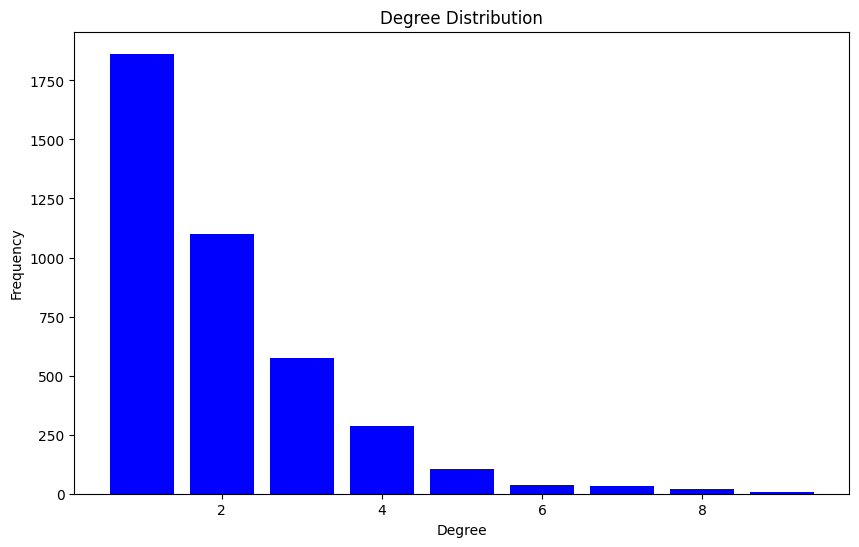

In [816]:
degree_sequence = [d for _, d in G.degree()]

# Count the frequency of each degree
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

probabilities = [freq / sum(cnt) for freq in cnt]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Now, we fit this degree distribution to a normal distribution, and sample from it to create our own degree distribution. In the graph we plot the original distribution, the normal distribution derived from it and the newly generated degree samples.

For the network generation, we made sure that the sum of the degrees in the sequence is even.

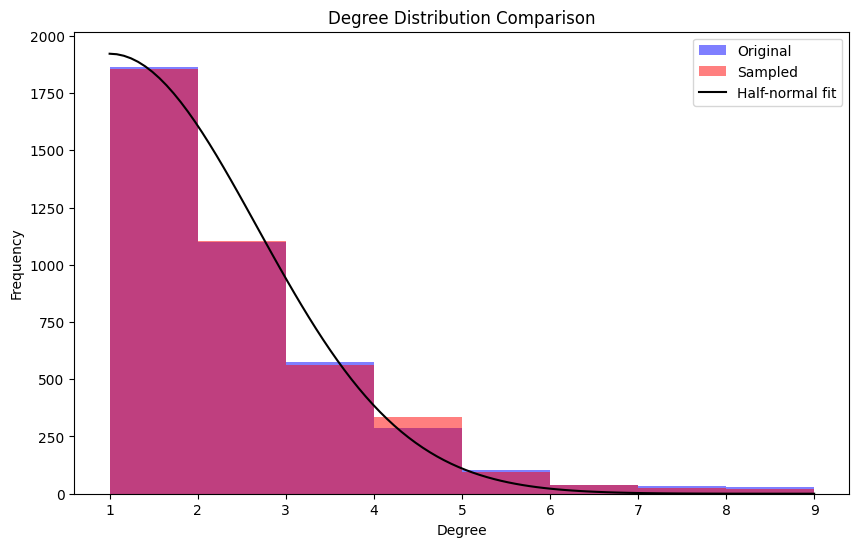

In [837]:
def make_degrees_sum_even(sequence):
    if sum(sequence) % 2 != 0:
        # Choose a random index
        random_index = np.random.choice(len(sequence))
        
        # Decide whether to add or subtract 1 with 50% probability
        adjustment = np.random.choice([1, -1])
        
        # Apply the adjustment
        sequence[random_index] += adjustment
    return sequence

num_nodes = len(degree_sequence)

# Generate a degree sequence following the original degree distribution
sampled_degree_sequence = np.random.choice(deg, size=num_nodes, p=probabilities)

sampled_degree_sequence = make_degrees_sum_even(sampled_degree_sequence)


# Plot the degree distribution comparison
plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence)+1), alpha=0.5, label='Original', color='b')
plt.hist(sampled_degree_sequence, bins=range(min(degree_sequence), max(degree_sequence)+1), alpha=0.5, label='Sampled', color='r')

params = stats.halfnorm.fit(degree_sequence)
x = np.linspace(1, max(degree_sequence), 100)
pdf_fitted = stats.halfnorm.pdf(x, *params) * sum(cnt)
plt.plot(x, pdf_fitted, label='Half-normal fit', color='black')



plt.title("Degree Distribution Comparison")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [839]:
G_simple = nx.configuration_model(sampled_degree_sequence)
nx.write_gexf(G_simple, "networks/simple_network.gexf")

print("-------- Avg. degree matching network: --------")
printStats(G_simple)

print("\n-------- Original network: --------")
printStats(G)

-------- Avg. degree matching network: --------
Nodes: 4030
Edges: 4061
Degree: (Min: 1, Max: 9, Avg: 2.0153846153846153)
Connected components: 328
Avg path length: 17.25483870967742
Diameter: 28
Radius: 14.0
Average clustering coeff: -1
Modularity: 0.8918583451660277

-------- Original network: --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.2997926267281111
Modularity: 0.9955115981374059


Nodes, edges and degrees are very similar in both models, as well as the size of the networks. However, the generated network has much fewer connected components than the original one. Also, the average path length is much longer than in the original network.

Additionally, the average cluster coefficient appears as -1 because it cannot be calculated for the generated network, as the nx.configuration_model() function yields a MultiGraph, which contains loops and parallel edges.

From the image it is clear that the main difference with the original network is the presence of a huge cluster in the middle of the graph.

![Image](renders/AvgDegreeNet.svg)

## Matching Avg. Degree and Connected Components Network

In the previous approach, we made a network that had the appropiate average degree, but had too few connected components (CC). In this section, we are going to obtain the size distribution of the CCs. Then we will extract the distribution of the degrees of the nodes for every CC size. Finally, we will use the CC size distribution and the degrees distribution for each size to create each of the components of the network.

First, we will obtain the cluster size distribution.

Text(0, 0.5, 'Frequency')

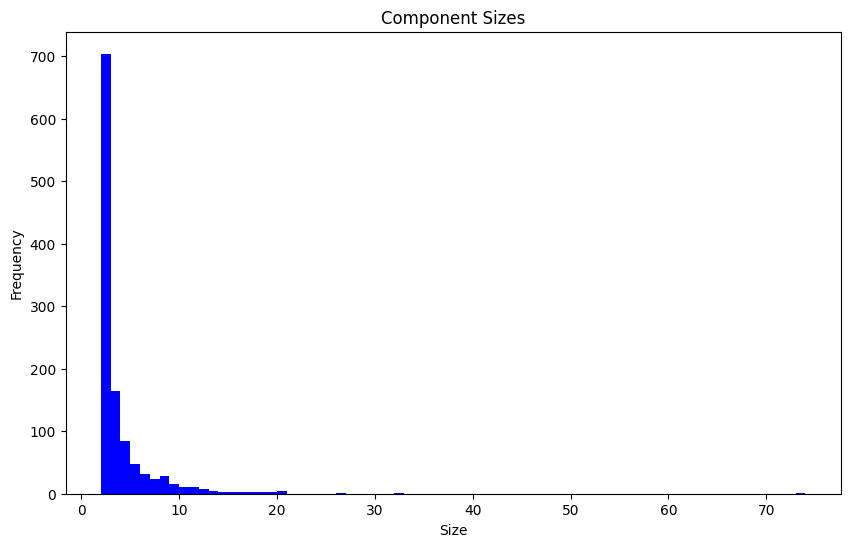

In [869]:
# Get the diff. network components
components = [G.subgraph(component).copy() for component in nx.connected_components(G)]
components_list = [list(component) for component in components]
component_sizes = [len(component) for component in components_list]

#plot histogram for component sizes

plt.figure(figsize=(10, 6))
plt.hist(component_sizes, bins=range(min(component_sizes), max(component_sizes)+1), color='b')
plt.title("Component Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")


As shown in the image, the distribution is not gaussian, so for obtaining the CC size sequence of the generated network we are going to sample directly from this distribution.

Now we will define the functions for extracting the degree distribution for each CC size.

In [862]:
from scipy.stats import truncnorm
def fit_truncated_normal(data, lower_bound, size):
    # Estimate the parameters of the normal distribution from the data
    mu, std = np.mean(data), np.std(data)
    if std == 0:
        print(size)

    # Create a truncated normal distribution with these parameters
    a, b = (lower_bound - mu) / std, np.inf
    dist = truncnorm(a, b, loc=mu, scale=std)  # Normalize the bounds (no upper bound)
    return dist 

def get_size_component_distribution(components_list, size, plot = False):

    selected_indexes = [index for index, component in enumerate(components_list) if len(component) == size]
    filtered_components = [components[index] for index in selected_indexes]

    degrees = []
    degrees = [d for component in filtered_components for _, d in component.degree()]
    min_degree = min(degrees)
    max_degree = max(degrees)

    distribution = fit_truncated_normal(degrees, 0.5, size) # Lower bound is 0.5 because we are rounding to the nearest integer when creating the histogram

    if plot:
        x = np.linspace(min_degree - 0.5, max_degree + 0.5, 1000)
        pdf = distribution.pdf(x)*len(degrees)
        plt.figure(figsize=(10, 6))
        plt.plot(x + 0.5, pdf, 'k', linewidth=2, label='Fitted Truncated Normal')
        plt.hist(degrees, bins=range(int(min_degree), int(max_degree+2)), color='b', label='Original')
        sampled_degree_sequence = distribution.rvs(size=len(degrees)).round().astype(int)
        plt.hist(sampled_degree_sequence, bins=range(int(min_degree), int(max_degree+2)), color='r', alpha=0.5, label='Sampled')
        plt.title(f"Degree Distribution for component size {size}")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.legend()

    return distribution

This is an example of the original distribution, the normal distribution and the samples obtained for the degrees of the nodes of a CC of size 6.

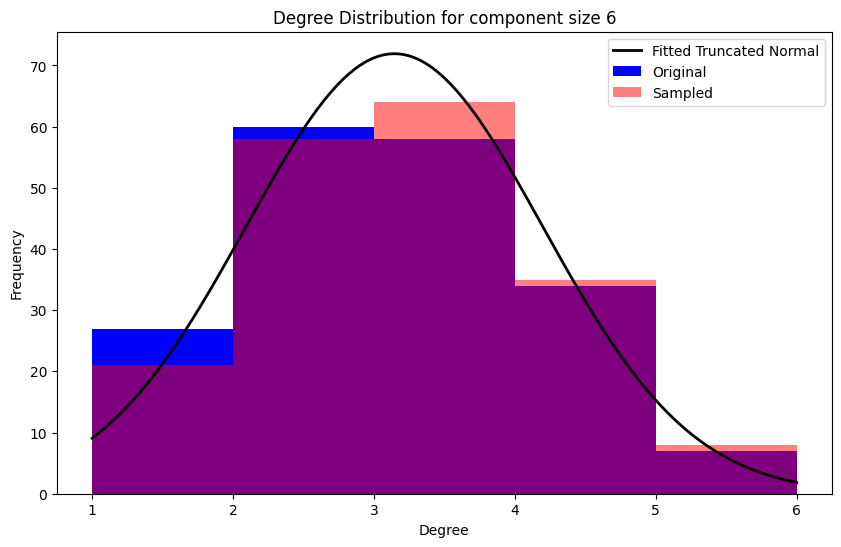

In [864]:
get_size_component_distribution(components_list, 6, True)


## Generating the Network

### CC size distribution
First of all, we will generate the size sequence for the CCs. In the plot there is the comparison between the generated distribution and the original one.



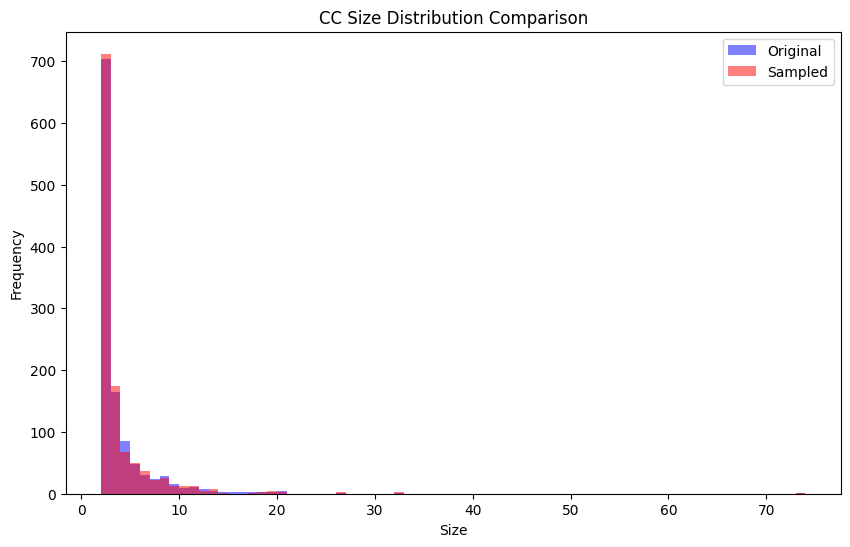

In [865]:
size_count = collections.Counter(component_sizes)
size, cnt = zip(*size_count.items())

probabilities = [freq / sum(cnt) for freq in cnt]

num_components = len(component_sizes)

# Generate a degree sequence following the original degree distribution
sampled_size_sequence = np.random.choice(size, size=num_components, p=probabilities)

plt.figure(figsize=(10, 6))
plt.hist(component_sizes, bins=range(min(component_sizes), max(component_sizes)+1), alpha=0.5, label='Original', color='b')
plt.hist(sampled_size_sequence, bins=range(min(size), max(size)+1), alpha=0.5, label='Sampled', color='r')
plt.title("CC Size Distribution Comparison")
plt.xlabel("Size")
plt.ylabel("Frequency")
plt.legend()

### Degree distribution
Secondly, we need the degree distribution for each CC size.

In [ ]:
# Getting the degree distributions:

all_distros = {}

for size in range(3, max(component_sizes)+1):
    if size not in component_sizes:
        continue
    distribution = get_size_component_distribution(components_list, size, False)
    all_distros[size] = distribution

Finally, we construct the network one component at a time by sampling the component size from the size distribution and generating a degree sequence by sampling from the degree distribution for that component size. All this components will be merged into a network.

In [ ]:
G_gen = nx.MultiGraph()

node_offset = 0

count = 0

for n_component in range(num_components):
    size = sampled_size_sequence[n_component]
    if (size == 2):
        degree_sequence = [1, 1]
    else:
        distribution = all_distros[size]
        degree_sequence = []
        for _ in range(size):
            degree = distribution.rvs().round().astype(int)
            if degree < 1:
                print('Degree < 1')
            degree_sequence.append(degree)
            
    degree_sequence = make_degrees_sum_even(degree_sequence)
    Component = nx.configuration_model(degree_sequence)
    mapping = {node: node + node_offset for node in Component.nodes()}
    Component = nx.relabel_nodes(Component, mapping)
    
    node_offset += size
    
    G_gen = nx.compose(G_gen, Component)



Nodes: 4008
Edges: 4225
Degree: (Min: 1, Max: 11, Avg: 2.1082834331337326)
Connected components: 1177
Avg path length: 2.3792415169660677
Diameter: 15
Radius: 7.5
Average clustering coeff: -1
Modularity: 0.9887400581211767


Before comparing this network with the original, we need to remove self-loops and isolated nodes, as these do not align with the nature of the original dataset.

In [ ]:
# Remove self-loops
G_gen.remove_edges_from(nx.selfloop_edges(G_gen))

# Remove isolated nodes
G_gen.remove_nodes_from(list(nx.isolates(G_gen)))


print("-------- Generated network: --------")
printStats(G_gen)

print("\n-------- Original network: --------")
printStats(G)

-------- Generated network: --------
Nodes: 4008
Edges: 4225
Degree: (Min: 1, Max: 11, Avg: 2.1082834331337326)
Connected components: 1177
Avg path length: 2.3792415169660677
Diameter: 15
Radius: 7.5
Average clustering coeff: -1
Modularity: 0.9887400581211767

-------- Original network: --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.2997926267281111
Modularity: 0.9955115981374059


With this newly generated network only the size of the network and the average path length differ slightly from the original one. Again, the clustering coefficient cannot be displayed, as the network generation was done using multigraphs.

Even though this metrics are really promising, there is one key difference between this new network and the original: The new network contains parallel edges, whereas the original network doesn't.

In [868]:
G_gen_no_parallel = nx.Graph(G_gen)
nx.write_gexf(G_gen_no_parallel, "networks/generated_network.gexf")

print("-------- Generated network (with no parallel edges): --------")
printStats(G_gen_no_parallel)

print("\n-------- Original network: --------")
printStats(G)

-------- Generated network (with no parallel edges): --------
Nodes: 4008
Edges: 3882
Degree: (Min: 1, Max: 11, Avg: 1.937125748502994)
Connected components: 1177
Avg path length: 2.3792415169660677
Diameter: 15
Radius: 7.5
Average clustering coeff: 0.11181462831911913
Modularity: 0.987688856294123

-------- Original network: --------
Nodes: 4030
Edges: 4078
Degree: (Min: 1, Max: 9, Avg: 2.023821339950372)
Connected components: 1155
Avg path length: 3.3406947890818857
Diameter: 27
Radius: 13.5
Average clustering coeff: 0.2997926267281111
Modularity: 0.9955115981374059


When we remove the parallel edges, the total number of edges and the average degree are slightly lower than in the original network. Additionally, the average clustering coefficient is noticeably smaller in the generated network.

The number of connected components (CCs) is also slightly higher than in the original network. This may be surprising, given that each component was created separately. However, this can be attributed to the use of the nx.configuration_model() function, which does not always produce a fully connected network.

From the image, the primary difference compared to the original network is that the larger connected components appear more interconnected in the generated version.

![Image](renders/CCNet.svg)

## Conclusions

By using the nx.configuration_model() function, we were able to recreate the original network almost perfectly, although we did not fully match the number of edges. This issue could potentially be addressed by adding a correction term to the degree distributions to make the average node degree more comparable between the networks. However, we leave this possibility for future research.